# Step #1 Load the Data

In [19]:
# A tutorial for this file is available at www.relataly.com
# Tested with Python 3.8.8, Matplotlib 3.5, Scikit-learn 0.24.1, Seaborn 0.11.1, numpy 1.19.5

import math
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white', { 'axes.spines.right': False, 'axes.spines.top': False})
from pandas.api.types import is_string_dtype, is_numeric_dtype 
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.inspection import permutation_importance

# Data Source: 
# https://www.kaggle.com/datasets/lepchenkov/usedcarscatalog

# Load train and test datasets
path = "https://raw.githubusercontent.com/flo7up/relataly_data/main/car_prices/train.csv"
df = pd.read_csv(path)
df.head()

# Set the targetname for regression
target_name = 'price_usd'

# Step #2 Univerariate Data Analysis 

[Text(0, 0, '0 (0.0%)'),
 Text(0, 0, '0 (0.0%)'),
 Text(0, 0, '0 (0.0%)'),
 Text(0, 0, '0 (0.0%)'),
 Text(0, 0, '0 (0.0%)'),
 Text(0, 0, '0 (0.0%)'),
 Text(0, 0, '0 (0.0%)'),
 Text(0, 0, '0 (0.0%)'),
 Text(0, 0, '0 (0.0%)'),
 Text(0, 0, '10 (0.0%)'),
 Text(0, 0, '0 (0.0%)'),
 Text(0, 0, '0 (0.0%)'),
 Text(0, 0, '0 (0.0%)'),
 Text(0, 0, '0 (0.0%)'),
 Text(0, 0, '0 (0.0%)'),
 Text(0, 0, '0 (0.0%)'),
 Text(0, 0, '0 (0.0%)'),
 Text(0, 0, '0 (0.0%)'),
 Text(0, 0, '0 (0.0%)'),
 Text(0, 0, '0 (0.0%)'),
 Text(0, 0, '0 (0.0%)'),
 Text(0, 0, '0 (0.0%)'),
 Text(0, 0, '0 (0.0%)'),
 Text(0, 0, '0 (0.0%)'),
 Text(0, 0, '0 (0.0%)'),
 Text(0, 0, '0 (0.0%)'),
 Text(0, 0, '0 (0.0%)'),
 Text(0, 0, '0 (0.0%)'),
 Text(0, 0, '0 (0.0%)'),
 Text(0, 0, '0 (0.0%)')]

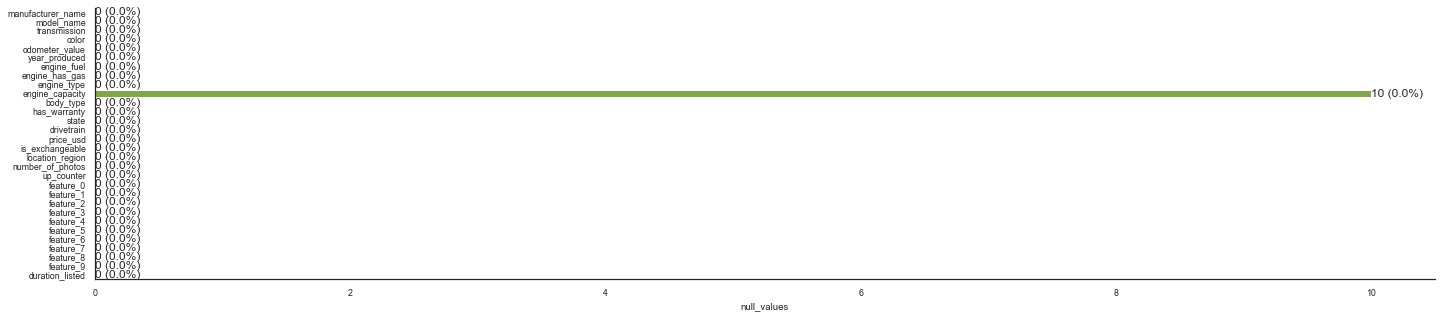

In [20]:
# Check for Missing Values
null_values = pd.DataFrame(df.isna().sum())
null_values.columns=['null_values']
plt.subplots(figsize=(24, 5))
ax = sns.barplot(data=pd.DataFrame(data=null_values), x='null_values', y=null_values.index)
pct_values = ['{:g}'.format(elm) + ' ({:.1%})'.format(elm/len(df)) for elm in list(null_values['null_values'])]
ax.bar_label(container=ax.containers[0], labels=pct_values, size=12)

In [21]:
# Identify columns with many missing values
df = df.fillna(0) # alternatively you can use .drop(columns=['engine_capacity'])  to replace the na values with 0 
df.head(2)

# Create a dataset with all features. This will allow us latere to train a full feature model to which we can compare our subset feature model
df_all = df.copy()

In [22]:
# Desccribe function
print(df.columns)
df.describe()

Index(['manufacturer_name', 'model_name', 'transmission', 'color',
       'odometer_value', 'year_produced', 'engine_fuel', 'engine_has_gas',
       'engine_type', 'engine_capacity', 'body_type', 'has_warranty', 'state',
       'drivetrain', 'price_usd', 'is_exchangeable', 'location_region',
       'number_of_photos', 'up_counter', 'feature_0', 'feature_1', 'feature_2',
       'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7',
       'feature_8', 'feature_9', 'duration_listed'],
      dtype='object')


,odometer_value,year_produced,engine_capacity,price_usd,number_of_photos,up_counter,duration_listed
count,38531.000000,38531.000000,38531.000000,38531.000000,38531.000000,38531.000000,38531.000000
mean,248864.638447,2002.943734,2.054628,6639.971021,9.649062,16.306091,80.577249
std,136072.376530,8.065731,0.671907,6428.152018,6.093217,43.286933,112.826569
min,0.000000,1942.000000,0.000000,1.000000,1.000000,1.000000,0.000000
25%,158000.000000,1998.000000,1.600000,2100.000000,5.000000,2.000000,23.000000
50%,250000.000000,2003.000000,2.000000,4800.000000,8.000000,5.000000,59.000000
75%,325000.000000,2009.000000,2.300000,8990.000000,12.000000,16.000000,91.000000
max,1000000.000000,2019.000000,8.000000,50000.000000,86.000000,1861.000000,2232.000000


categorical features: 9


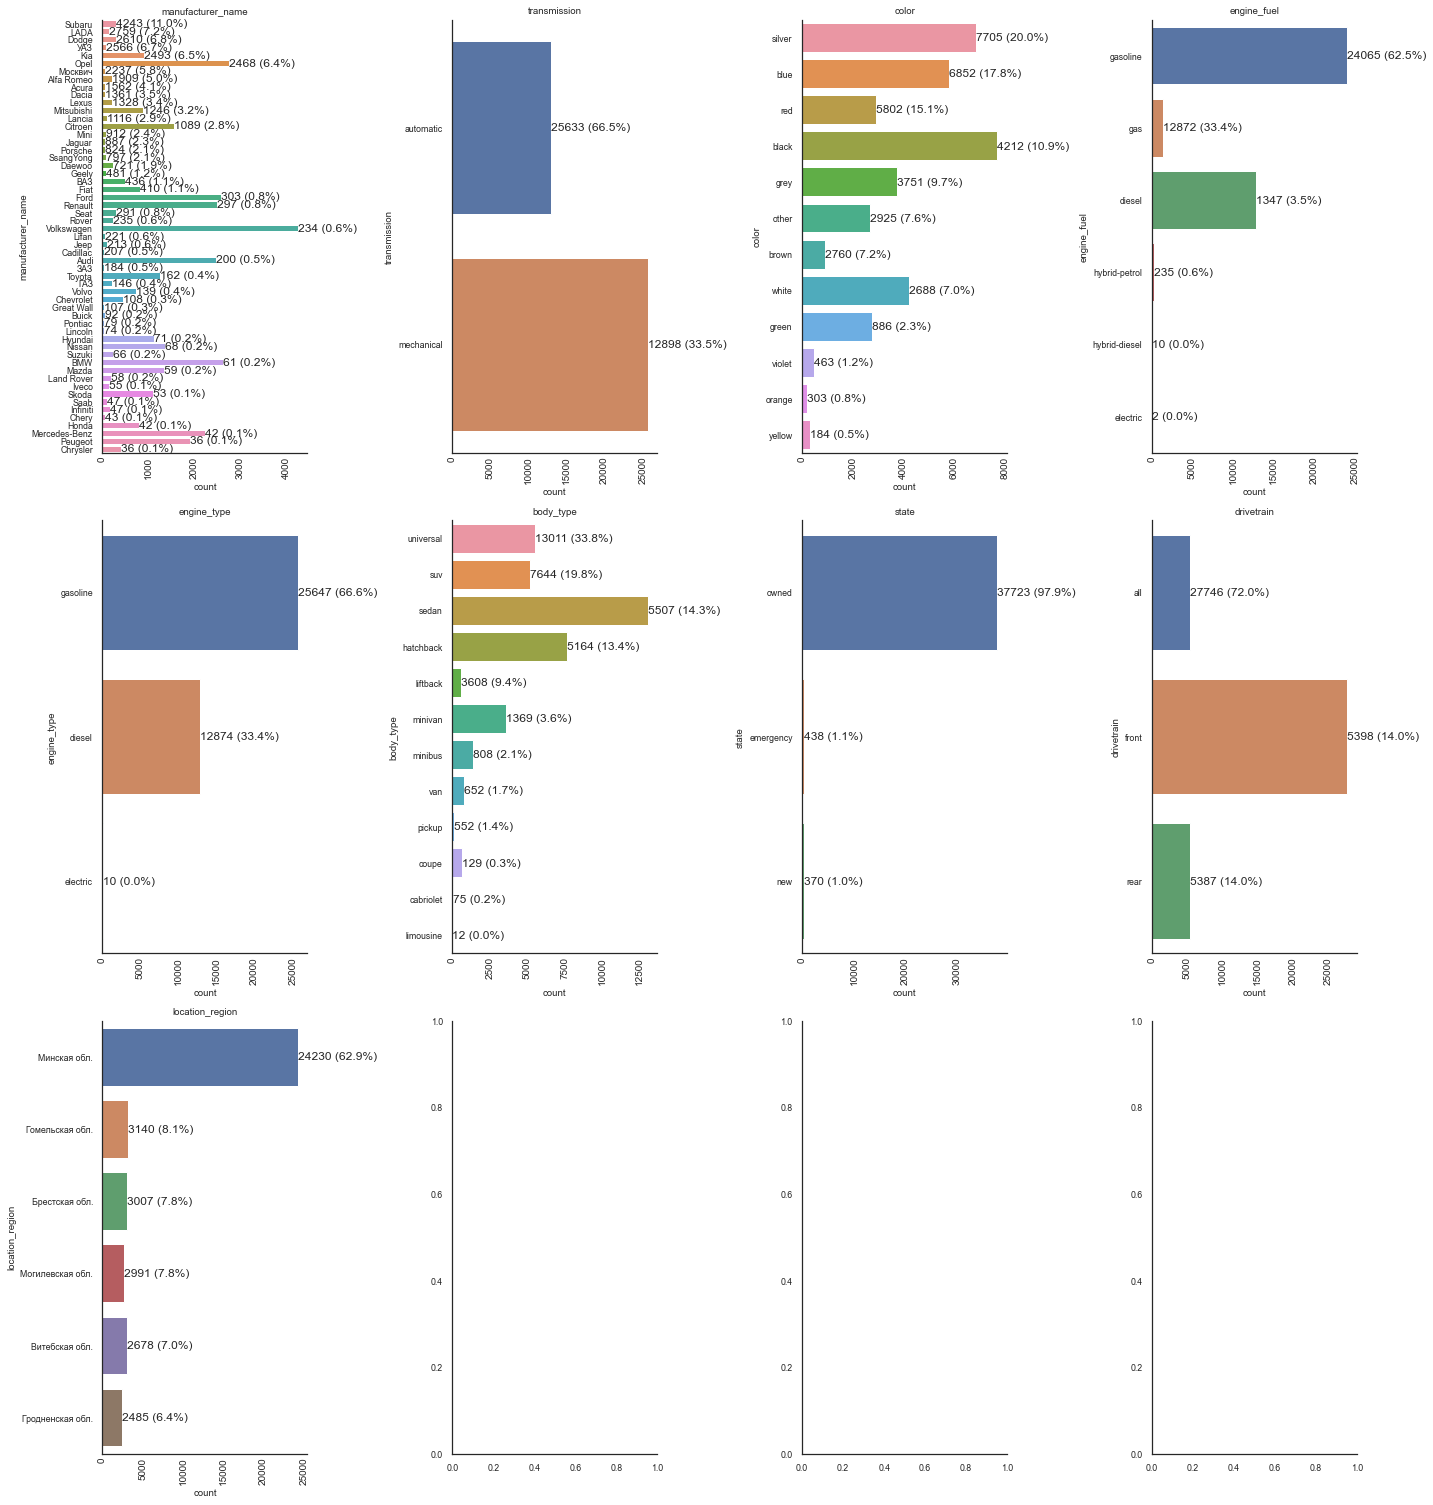

In [23]:
# Barplots to visualize the distribution of categorical variables
f_list = [x for x in df.columns if is_string_dtype(df[x])]
f_list.remove('model_name')
f_list_len = len(f_list)

print(f'categorical features: {f_list_len}')

# Adjust plotsize based on the number of features
ncols = 4
nrows = math.ceil(f_list_len / ncols)
fig, axs = plt.subplots(nrows, ncols, figsize=(20, nrows*7))
for i, ax in enumerate(fig.axes):
    if i < f_list_len:
        column_name = f_list[i]
        sns.countplot(data=df, y=column_name, ax = ax)
        pct_values = ['{:g}'.format(elm) + ' ({:.1%})'.format(elm/len(df)) for elm in list(df[column_name].value_counts())]
        ax.bar_label(container=ax.containers[0], labels=pct_values, size=12)
        ax.tick_params(axis="x", rotation=90, labelsize=10, length=0)
        ax.set_title(column_name)
        fig.tight_layout()

In [24]:
# Drop features with low variety
df = df.drop(columns=['state', 'location_region'])
df.head(2)

,manufacturer_name,model_name,transmission,color,odometer_value,year_produced,engine_fuel,engine_has_gas,engine_type,engine_capacity,...,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,duration_listed
0,Subaru,Outback,automatic,silver,190000,2010,gasoline,False,gasoline,2.5,...,True,True,True,False,True,False,True,True,True,16
1,Subaru,Outback,automatic,blue,290000,2002,gasoline,False,gasoline,3.0,...,True,False,False,True,True,False,False,False,True,83


Text(0.5, 1.0, 'price_usd Distribution')

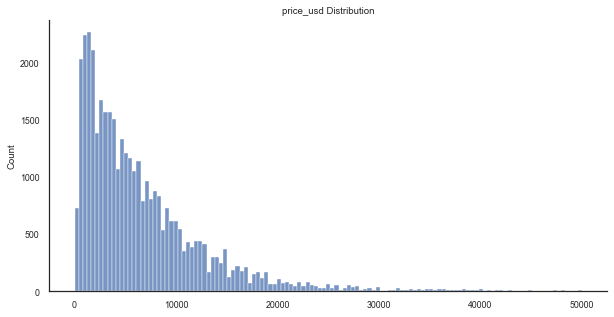

In [25]:
# Explore the distrution of specific variables
variable_name = target_name
fig, ax = plt.subplots(figsize=(10,5))
sns.histplot(data=df[[variable_name]].dropna(), ax=ax)
ax.get_legend().remove()
plt.title(variable_name + ' Distribution')

# Step #3 Bivariate Analysis

numeric features: 26
transmission
color
odometer_value
year_produced
engine_fuel
engine_has_gas
engine_type
engine_capacity
body_type
has_warranty
drivetrain
price_usd
is_exchangeable
number_of_photos
up_counter
feature_0
feature_1
feature_2
feature_3
feature_4
feature_5
feature_6
feature_7
feature_8
feature_9
duration_listed


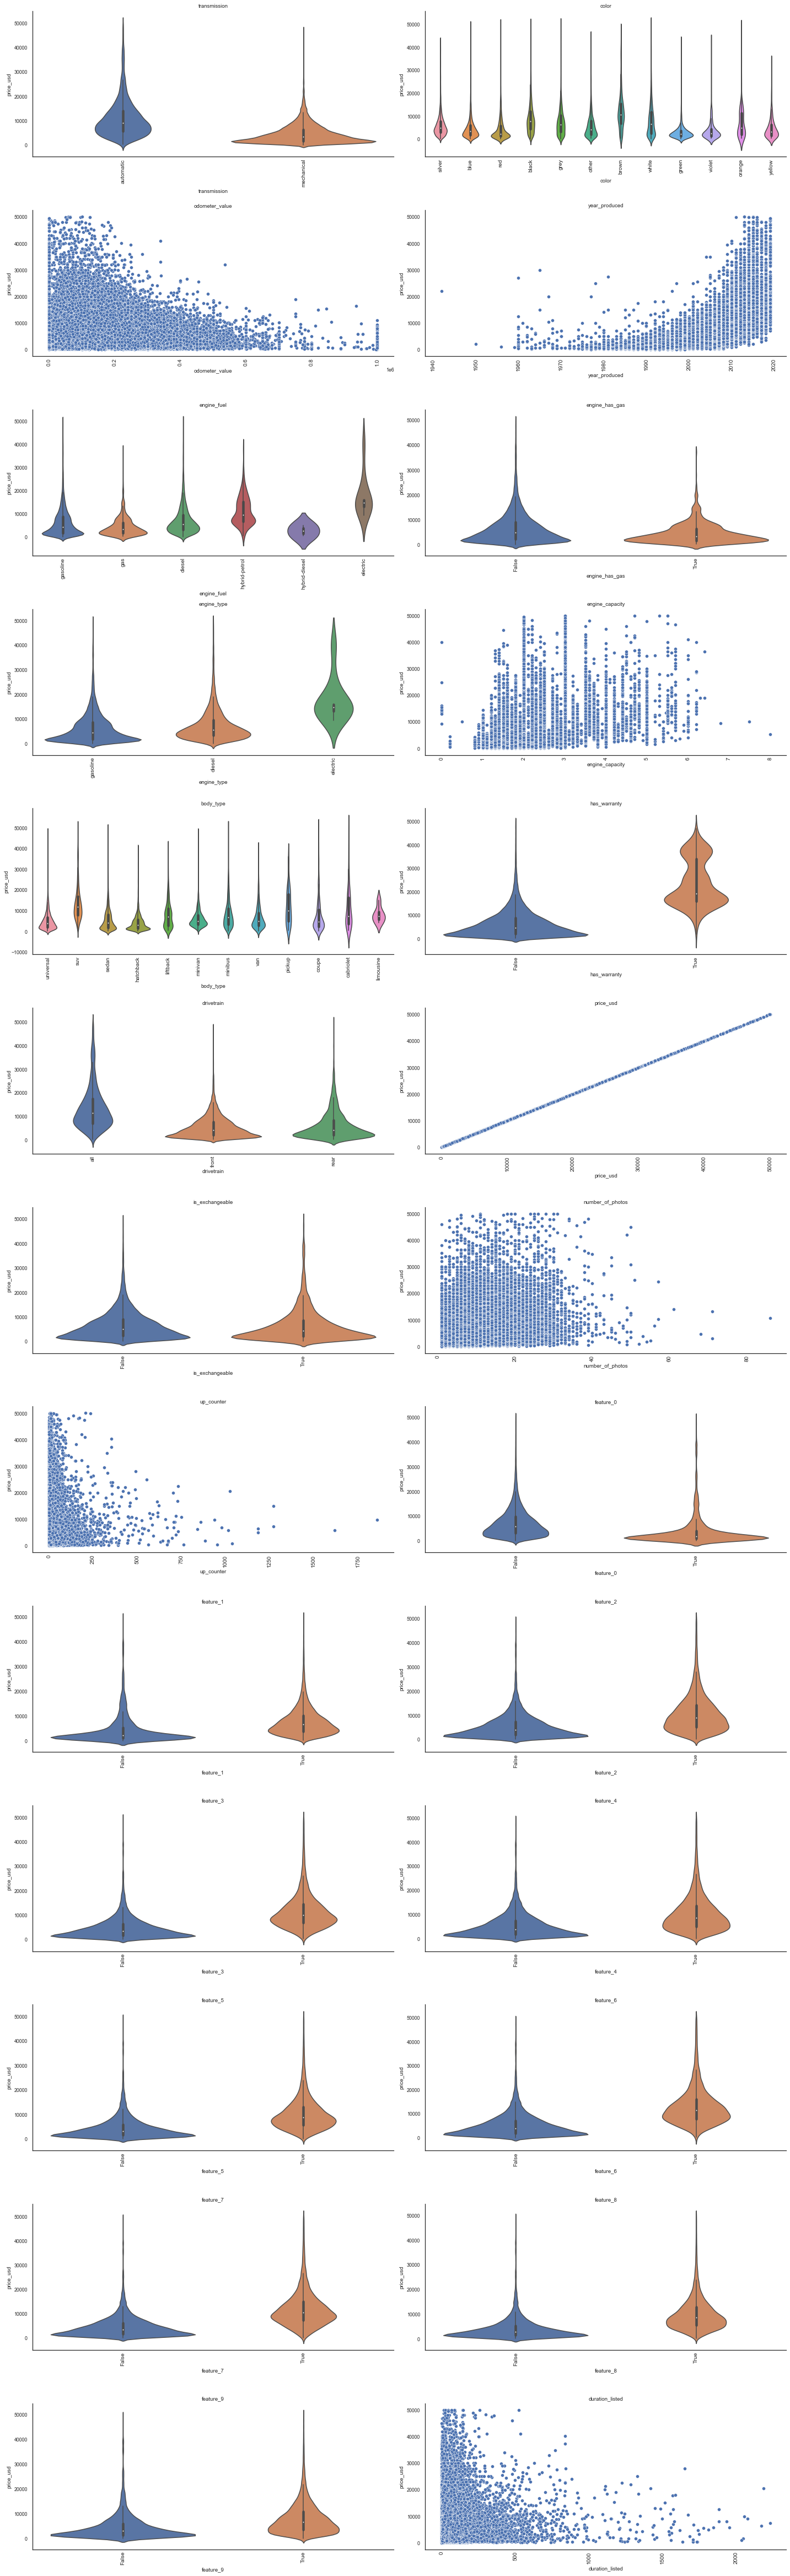

In [26]:
# Vizualising Distributions
f_list = [x for x in df.columns if (is_numeric_dtype(df[x])) or df[x].nunique() < 20]
f_list_len = len(f_list)
print(f'numeric features: {f_list_len}')

# Adjust plotsize based on the number of features
ncols = 2
nrows = math.ceil(f_list_len / ncols)
fig, axs = plt.subplots(nrows, ncols, figsize=(20, nrows*5))
for i, ax in enumerate(fig.axes):
    if i < f_list_len:
        column_name = f_list[i]
        print(column_name)
        # If a variable has more than 8 unique values draw a scatterplot, else draw a violinplot 
        if df[column_name].nunique() > 14:
            # Draw a scatterplot for each variable and target_name
            sns.scatterplot(data=df, y=target_name, x=column_name, ax = ax)
        else: 
            # Draw a vertical violinplot (or boxplot) grouped by a categorical variable:
            sns.violinplot(data=df, x=column_name, y=target_name, ax = ax)
            #sns.boxplot(data=df, x=column_name, y=target_name, ax = ax)
        ax.tick_params(axis="x", rotation=90, labelsize=10, length=0)
        ax.set_title(column_name)
    fig.tight_layout()

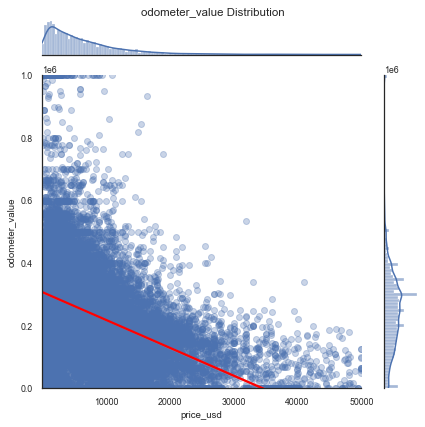

In [27]:
# Explore the distrution of specific variables
feature_name = 'odometer_value'

p = sns.jointplot(data=df, y=feature_name, x=target_name, height=6, ratio=6, kind='reg', joint_kws={'line_kws':{'color':'red'}})
# Alternatively you can use hex_binning
# p = sns.jointplot(data=df, y=feature_name, x=target_name, height=10, ratio=6, kind="hex")

p.fig.suptitle(feature_name + ' Distribution')
p.ax_joint.collections[0].set_alpha(0.3)
p.ax_joint.set_ylim(df[feature_name].min(),df[feature_name].max())
p.fig.tight_layout()
p.fig.subplots_adjust(top=0.95)

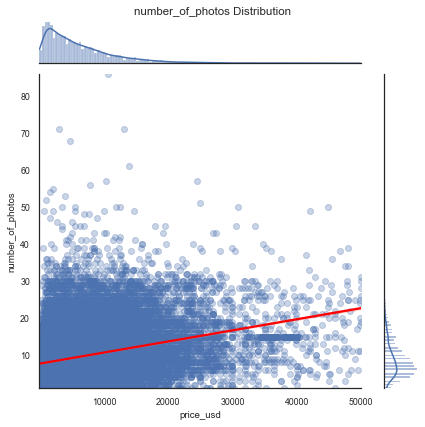

In [28]:
# Explore the distrution of specific variables
feature_name = 'number_of_photos'

p = sns.jointplot(data=df, y=feature_name, x=target_name, height=6, ratio=6, kind='reg', joint_kws={'line_kws':{'color':'red'}})
# Alternatively you can use hex_binning
# p = sns.jointplot(data=df, y=feature_name, x=target_name, height=10, ratio=6, kind="hex")

p.fig.suptitle(feature_name + ' Distribution')
p.ax_joint.collections[0].set_alpha(0.3)
p.ax_joint.set_ylim(df[feature_name].min(),df[feature_name].max())
p.fig.tight_layout()
p.fig.subplots_adjust(top=0.95)

In [29]:
# Drop features with low variety
df = df.drop(columns=['is_exchangeable', 'engine_has_gas', 'number_of_photos'])
df.head(2)

,manufacturer_name,model_name,transmission,color,odometer_value,year_produced,engine_fuel,engine_type,engine_capacity,body_type,...,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,duration_listed
0,Subaru,Outback,automatic,silver,190000,2010,gasoline,gasoline,2.5,universal,...,True,True,True,False,True,False,True,True,True,16
1,Subaru,Outback,automatic,blue,290000,2002,gasoline,gasoline,3.0,universal,...,True,False,False,True,True,False,False,False,True,83


# Step #4 Correlation Analysis

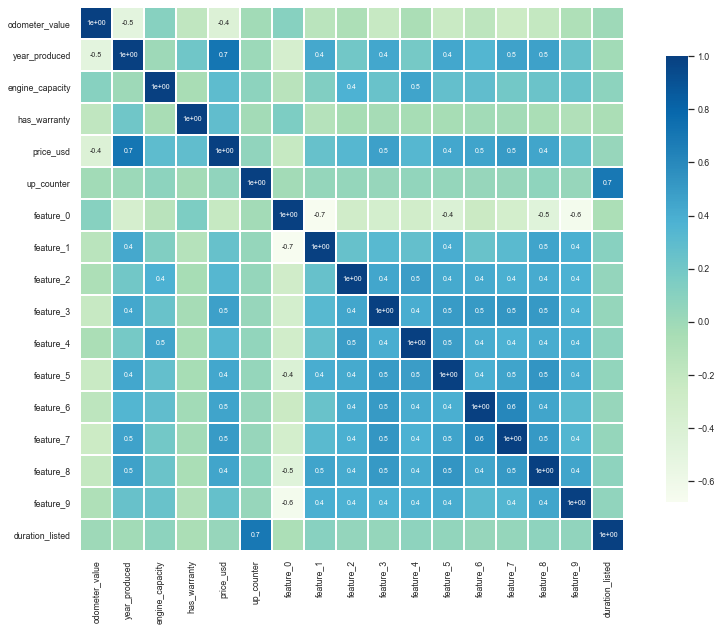

In [30]:
# Correlation Analysis: Heatmap facilitates the identification of highly correlated explanatory variables and reduce collinearity
plt.figure(figsize = (15,10))
plt.yticks(rotation=0)
correlation = df.corr()
ax =  sns.heatmap(correlation, cmap='GnBu',square=True, linewidths=.1, cbar_kws={"shrink": .82},annot=True,
            fmt='.1',annot_kws={"size":7})
sns.set(font_scale=0.8)
for f in ax.texts:
    if float(f.get_text())>=0.4:
        f.set_text(f.get_text()) #if the value is greater than 0.4 then I set the text 
    elif float(f.get_text())<=-0.4:
        f.set_text(f.get_text()) #if the value is greater than 0.4 then I set the text 
    else:
        f.set_text("") # if not it sets an empty text

In [31]:
# Drop one of the high correlated feature pairs
df_reduced_ = df.drop(columns=['duration_listed', 'feature_3', 'feature_5', 'feature_8', 'has_warranty', 'up_counter', 'duration_listed'])

# Drop features that are low correlated with the target variable
df_subset = df_reduced_.drop(columns=['feature_0'])

# Show the subset and the all df features
df_subset.head(2)
sub_df_feature_num = len(df_subset.columns)
all_df_feature_num = len(df_all.columns)
print(list(df_subset.columns))
print(list(df_all.columns))
print(f'features in the subset: {sub_df_feature_num}')
print(f'features in the full dataset: {all_df_feature_num}')

['manufacturer_name', 'model_name', 'transmission', 'color', 'odometer_value', 'year_produced', 'engine_fuel', 'engine_type', 'engine_capacity', 'body_type', 'drivetrain', 'price_usd', 'feature_1', 'feature_2', 'feature_4', 'feature_6', 'feature_7', 'feature_9']
['manufacturer_name', 'model_name', 'transmission', 'color', 'odometer_value', 'year_produced', 'engine_fuel', 'engine_has_gas', 'engine_type', 'engine_capacity', 'body_type', 'has_warranty', 'state', 'drivetrain', 'price_usd', 'is_exchangeable', 'location_region', 'number_of_photos', 'up_counter', 'feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9', 'duration_listed']
features in the subset: 18
features in the full dataset: 30


# Step #5 Preprocessing

In [32]:
def splitting(df):

    # Create a list of categorical variables that we want to encode
    categorical_list = [x for x in df.columns if is_string_dtype(df[x])]
    le = LabelEncoder()
    # Apply the encoding to the categorical variables
    # Since, the apply() function has no inplace argument,  we must use the following syntax to transform the df
    df[categorical_list] = df[categorical_list].apply(LabelEncoder().fit_transform)
    
    # # Separate labels from training data
    X = df.drop(columns=[target_name])
    y = df[target_name] #Prediction label

    # Split the data into x_train and y_train data sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=0)

    # Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
    print('train and test shapes')
    print(X_train.shape, y_train.shape)
    print(X_test.shape, y_test.shape)
    return X, y, X_train, X_test, y_train, y_test

# Step #6 Model Training

In [33]:
def train_model(X, y, X_train, y_train):
    estimator = DecisionTreeRegressor()
    scores = cross_val_score(estimator, X, y, cv=10)
    estimator.fit(X_train, y_train)
    return scores, estimator

# Train the model with the subset of selected features
X_sub, y_sub, X_train_sub, X_test_sub, y_train_sub, y_test_sub = splitting(df_subset)
scores_sub, estimator_sub = train_model(X_sub, y_sub, X_train_sub, y_train_sub)
    
# Train the model with all features
X_all, y_all, X_train_all, X_test_all, y_train_all, y_test_all = splitting(df_all)
scores_all, estimator_all = train_model(X_all, y_all, X_train_all, y_train_all)

train and test shapes
(26971, 17) (26971,)
(11560, 17) (11560,)
train and test shapes
(26971, 29) (26971,)
(11560, 29) (11560,)


# Step #7 Model Comparison - Subset vs All

       price_usd  PredictedPrice
5309      3500.0          5200.0
15125     5450.0          5400.0
23473     3000.0          2500.0
28812     5490.0          5500.0
7903      1990.0          3000.0
Mean Absolute Error (MAE): 1512.88
Median Absolute Percentage Error (MAPE): 43.61 %
       price_usd  PredictedPrice
5309      3500.0          4500.0
15125     5450.0          5200.0
23473     3000.0          3300.0
28812     5490.0          4200.0
7903      1990.0          1300.0
Mean Absolute Error (MAE): 1622.03
Median Absolute Percentage Error (MAPE): 85.77 %


Text(0.5, 1.0, 'Cross validation scores of the full dataset model')

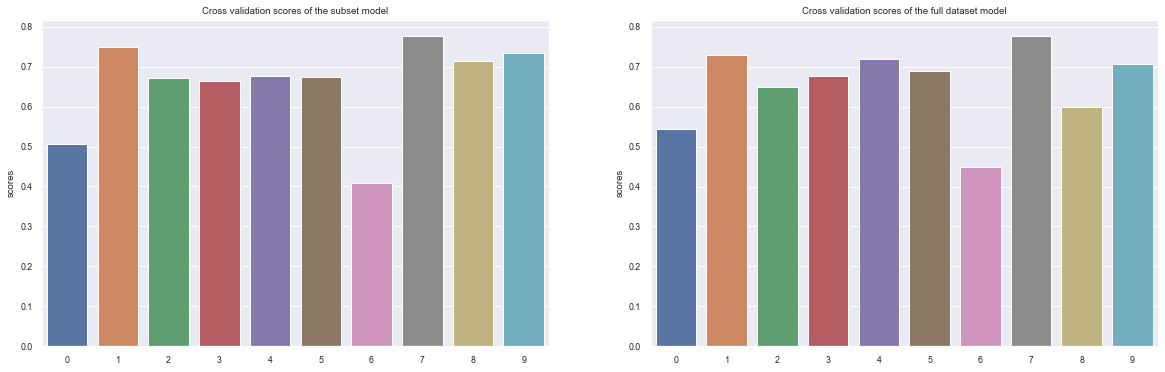

In [34]:
def create_metrics(scores, estimator, X_test, y_test):
    scores_df = pd.DataFrame({'scores':scores})

    y_pred = estimator.predict(X_test)
    y_df = pd.DataFrame(y_test)
    y_df['PredictedPrice']=y_pred
    print(y_df.head())

    # Mean Absolute Error (MAE)
    MAE = mean_absolute_error(y_pred, y_test)
    print('Mean Absolute Error (MAE): ' + str(np.round(MAE, 2)))

    # Mean Absolute Percentage Error (MAPE)
    MAPE = mean_absolute_percentage_error(y_pred, y_test)
    print('Median Absolute Percentage Error (MAPE): ' + str(np.round(MAPE*100, 2)) + ' %')
    
    # Feature Importance
    r = permutation_importance(estimator, X_test, y_test, n_repeats=30, random_state=0)
    data_im = pd.DataFrame(r.importances_mean, columns=['feature_permuation_score'])
    data_im['feature_names'] = X_test.columns
    data_im = data_im.sort_values('feature_permuation_score', ascending=False)
    
    return scores_df, data_im

scores_df_sub, data_im_sub = create_metrics(scores_sub, estimator_sub, X_test_sub, y_test_sub)
scores_df_all, data_im_all = create_metrics(scores_all, estimator_all, X_test_all, y_test_all)

fig, axs = plt.subplots(1, 2, figsize=(20, 6))
sns.barplot(data=scores_df_sub, y='scores', x =scores_df_sub.index, ax=axs[0])
axs[0].set_title('Cross validation scores of the subset model')
sns.barplot(data=scores_df_all, y='scores', x =scores_df_all.index, ax=axs[1])
axs[1].set_title('Cross validation scores of the full dataset model')

Text(0.5, 1.0, 'Feature importance scores of the full dataset model')

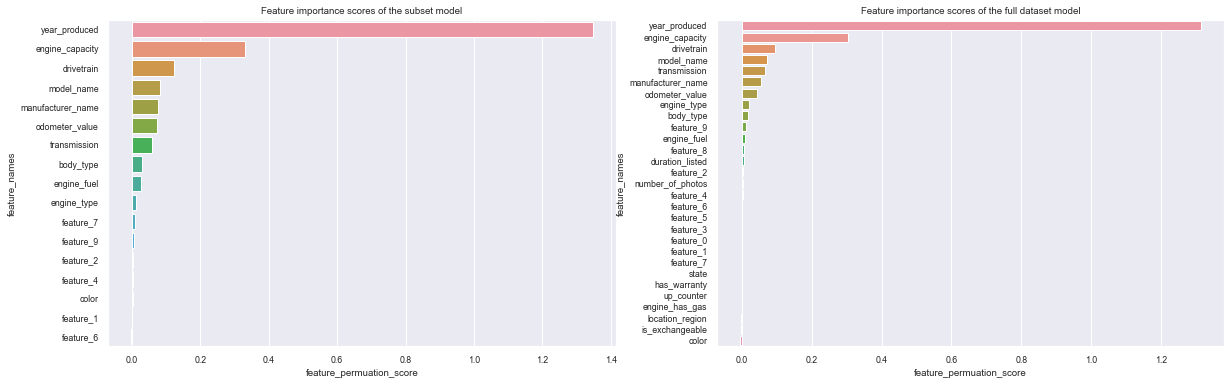

In [35]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))
sns.barplot(data=data_im_sub, y='feature_names', x="feature_permuation_score", ax=axs[0])
axs[0].set_title("Feature importance scores of the subset model")
sns.barplot(data=data_im_all, y='feature_names', x="feature_permuation_score", ax=axs[1])
axs[1].set_title("Feature importance scores of the full dataset model")